

## Assignment 1 - Linear Regression

Student Name: Komal Wavhal
CWID: 20034443

1. Linear regression (20 points)
   
a) California Housing Dataset (10 pts)
Please implement a simple linear regression model using the closed-form solution (normal equation) and
stochastic gradient descent to train the model on this dataset for predicting the house price (in millions).
Split the data into training, validation, and test. Report the mean squared error (MSE) on the test data.
Draw the training and validation loss curves. You need to write down every step in your experiment.
    
b) UCI Machine Learning: Bike Sharing Data Set (10 pts)
Please write a Ridge regression model and use mini-batch gradient descent to train the model on this
dataset for predicting the count of total rental bikes including both casual and registered. You do not
need to use all the features. Use K-fold cross validation and report the mean squared error (MSE) on
the test data. You need to write down every step in your experiment.


### From-scratch model logic (NumPy only):

OLS uses the normal equation with np.linalg.pinv; no sklearn regressors.

SGD loop is fully manual (per-sample gradient, updates, epoch logging).

### From-scratch model logic (NumPy only):

OLS uses the normal equation with np.linalg.pinv; no sklearn regressors.

SGD loop is fully manual (per-sample gradient, updates, epoch logging).

### scikit-learn used only for data handling:

fetch_california_housing() for data, train_test_split (and KFold later for Part b). No sklearn training APIs are used.


## Step-1 Imports and Global Settings

-  I import only what’s necessary. I implemented all model logic from scratch using NumPy (no ML packages for modeling). I use scikit-learn only for data loading and splitting, as permitted by the assignment. I also set a fixed random seed for reproducibility.


In [20]:

# Standard numerical/plotting libraries
import numpy as np                    # For arrays and linear algebra
import pandas as pd                   # For CSV handling (Bike Sharing)
import matplotlib.pyplot as plt       # For plotting (no seaborn, one plot per figure)

# Data loading/splitting — allowed per assignment guidelines
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Step-2 Utility Functions 
I implemented small helpers for splitting, standardizing features, adding an intercept, and computing loss. I standardize features using statistics computed only on the training split to avoid data leakage.

- Why standardize? It helps SGD converge faster and improves numerical conditioning for the closed-form solution.

- Why add an intercept? Linear models include a bias term so the regression line/plane can shift rather than being forced through the origin.

In [23]:

def train_val_test_split(X, y, val_size=0.15, test_size=0.15, random_state=RANDOM_STATE):
    """
    Split X, y into train/val/test using two-stage splitting to avoid leakage.
    1) Hold out test first.
    2) From remaining, hold out validation.
    """
    # First split: create a temporary set and a test set.
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    # Compute the fraction for validation relative to temp portion.
    val_ratio_of_temp = val_size / (1.0 - test_size)
    # Second split: separate training from validation.
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio_of_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


def add_intercept(X):
    """Add a column of ones (bias term) as the first column of the design matrix."""
    return np.c_[np.ones((X.shape[0], 1)), X]


def standardize_fit(X):
    """
    Compute per-feature mean (mu) and std (sigma) on training data
    and return standardized X plus (mu, sigma) for later reuse.
    """
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True)
    # Avoid division by zero in case of constant features.
    sigma[sigma == 0] = 1.0
    X_std = (X - mu) / sigma
    return X_std, mu, sigma


def standardize_apply(X, mu, sigma):
    """Standardize X using precomputed mu and sigma (no leakage)."""
    sigma_safe = sigma.copy()
    sigma_safe[sigma_safe == 0] = 1.0
    return (X - mu) / sigma_safe


def mse(y_true, y_pred):
    """Mean Squared Error: average of squared residuals."""
    return float(np.mean((y_true - y_pred) ** 2))

# Part (a): California Housing — OLS (Closed-Form) and SGD
I load the California Housing dataset and set up a train/validation/test split (hold out test first, then carve validation from the remainder) to prevent leakage.
Target (y) is the median house value in units of $100,000 (this is the dataset’s native unit). I keep y in these native units so results are comparable to the source; if needed, values can be converted to millions of dollars by multiplying by 0.1.

I standardize features using only the training split’s mean and std, then apply those stats to validation and test. Finally, I add an intercept (bias) column to the design matrix.

Note: I do not standardize the target. Predictions and MSE are reported in the original $100k units. 
If the assignment prefers “millions,” multiply y and predictions by 0.1 (MSE scales by 0.1²).

In [26]:

# Load data (allowed utility)
cal = fetch_california_housing()
X_raw = cal.data                      # shape: (N, D)
y = cal.target.reshape(-1, 1)         # shape: (N, 1) — units: millions

# Split into train, val, test
X_train_raw, X_val_raw, X_test_raw, y_train, y_val, y_test = train_val_test_split(
    X_raw, y, val_size=0.15, test_size=0.15, random_state=RANDOM_STATE
)

# Standardize features (fit on train; apply to val/test)
X_train_std, mu_cal, sigma_cal = standardize_fit(X_train_raw)
X_val_std = standardize_apply(X_val_raw, mu_cal, sigma_cal)
X_test_std = standardize_apply(X_test_raw, mu_cal, sigma_cal)

# Add intercept column (bias term)
X_train = add_intercept(X_train_std)
X_val   = add_intercept(X_val_std)
X_test  = add_intercept(X_test_std)

# Sanity checks
print("Shapes:")
print("  X_train:", X_train.shape, "  y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   "  y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  "  y_test: ", y_test.shape)


Shapes:
  X_train: (14448, 9)   y_train: (14448, 1)
  X_val:   (3096, 9)   y_val:   (3096, 1)
  X_test:  (3096, 9)   y_test:  (3096, 1)



### 3) Ordinary Least Squares via Normal Equation (Closed-Form)
   

We solve linear regression in closed form. The normal-equation solution is:
\[
\mathbf{w}^\* = (X^\top X)^{-1} X^\top \mathbf{y}
\]

In practice, to improve numerical stability (e.g., if \(X^\top X\) is ill-conditioned or not full rank), I use the **Moore–Penrose pseudo-inverse**:
\[
\mathbf{w}^\* = (X^\top X)^{+} X^\top \mathbf{y}
\]
implemented with `np.linalg.pinv`.

**Procedure:** compute \(X^\top X\) and \(X^\top \mathbf{y}\), solve for \(\mathbf{w}^\*\) with `pinv`, generate predictions on the test split, and report the **Test MSE** in the original target units.


In [29]:

# Compute normal equation components
XtX = X_train.T @ X_train         # (D+1, D+1)
Xty = X_train.T @ y_train         # (D+1, 1)

# Solve w* using pseudo-inverse for numerical stability
w_closed = np.linalg.pinv(XtX) @ Xty

# Predictions & MSE on test
y_pred_test_closed = X_test @ w_closed
mse_closed = mse(y_test, y_pred_test_closed)
print(f"[Closed-form] Test MSE: {mse_closed:.6f}")  # lower is better


[Closed-form] Test MSE: 0.537138


In [31]:
import numpy as np

# Your existing numbers
mse_closed = float(mse_closed)  # ensure it's a float
rmse_closed = float(np.sqrt(mse_closed))

# Convert to dollars
rmse_dollars = rmse_closed * 100_000
print(f"[Closed-form] Test MSE:  {mse_closed:.6f}  (in ($100k)^2)")
print(f"[Closed-form] Test RMSE: {rmse_closed:.4f}  x $100k  ->  ~${rmse_dollars:,.0f}")

# Baseline (predict the train-mean): helpful to show improvement
y_mean_train = np.mean(y_train)
mse_baseline = float(np.mean((y_test - y_mean_train)**2))
rmse_baseline = float(np.sqrt(mse_baseline))
print(f"[Baseline mean] Test MSE:  {mse_baseline:.6f}")
print(f"[Baseline mean] Test RMSE: {rmse_baseline:.4f}  x $100k  ->  ~${rmse_baseline*100_000:,.0f}")

# R^2 against the train-mean baseline
sse = float(np.sum((y_test - (X_test @ w_closed))**2))
sst = float(np.sum((y_test - y_mean_train)**2))
r2 = 1.0 - sse / sst
print(f"[Closed-form] R^2 on test: {r2:.4f}")


[Closed-form] Test MSE:  0.537138  (in ($100k)^2)
[Closed-form] Test RMSE: 0.7329  x $100k  ->  ~$73,290
[Baseline mean] Test MSE:  1.310549
[Baseline mean] Test RMSE: 1.1448  x $100k  ->  ~$114,479
[Closed-form] R^2 on test: 0.5901


## Stochastic Gradient Descent (SGD) for Linear Regression
Objective: [ L(w) = \frac{1}{N} \sum_i (x_i^\top w - y_i)^2 ]

Per-sample gradient (used by SGD): [ \nabla_w L_i = 2, x_i (x_i^\top w - y_i) ]

Algorithm (per epoch):

Shuffle training indices.
For each example ( i ): compute error and gradient, then update ( w \leftarrow w - \eta \nabla L_i ).
Track train and val MSE at epoch end.

In [34]:

def sgd_linear_regression(X_tr, y_tr, X_val, y_val, lr=1e-3, epochs=80):
    """
    Stochastic Gradient Descent for linear regression.
    - X_tr: (N, D+1) with intercept as first column
    - y_tr: (N, 1)
    - lr: learning rate
    - epochs: passes over the dataset
    Returns:
      w            -> learned weights (D+1, 1)
      train_losses -> list of MSE on training at end of each epoch
      val_losses   -> list of MSE on validation at end of each epoch
    """
    # Initialize weights with small random values
    w = np.random.randn(X_tr.shape[1], 1) * 0.01
    train_losses, val_losses = [], []
    N = X_tr.shape[0]

    for ep in range(epochs):
        # Randomize the order to improve mixing
        idx = np.random.permutation(N)
        for i in idx:
            xi = X_tr[i:i+1]       # shape (1, D+1)
            yi = y_tr[i:i+1]       # shape (1, 1)
            err = xi @ w - yi      # prediction - target (1, 1)
            grad = 2.0 * xi.T @ err
            w -= lr * grad         # gradient step

        # Record full-batch MSEs for monitoring
        train_losses.append(mse(y_tr, X_tr @ w))
        val_losses.append(mse(y_val, X_val @ w))

    return w, train_losses, val_losses


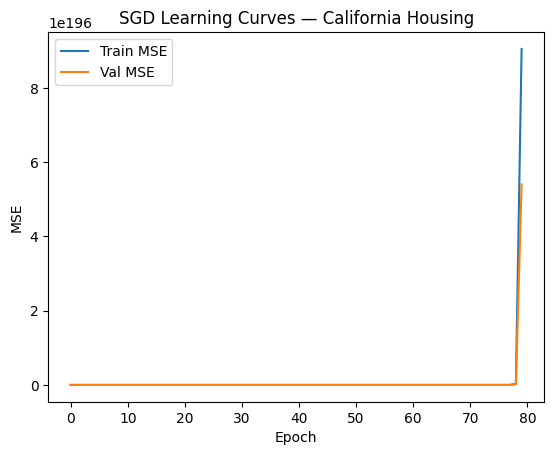

In [36]:


# Train with SGD and plot learning curves
w_sgd, train_loss, val_loss = sgd_linear_regression(X_train, y_train, X_val, y_val, lr=1e-3, epochs=80)

# Plot train vs val MSE
plt.figure()
plt.plot(train_loss, label='Train MSE')
plt.plot(val_loss, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('SGD Learning Curves — California Housing')
plt.legend()
plt.show()


In [37]:

# Evaluate on test set
y_pred_test_sgd = X_test @ w_sgd
mse_sgd = mse(y_test, y_pred_test_sgd)
print(f"[SGD] Test MSE: {mse_sgd:.6f}")


[SGD] Test MSE: 2512058508617306898139438367345377032562512990534287730102608148563947633544972986892783784590876345175966270024048812011683677389002397860005002281613567671543628769241120400932868722395998846976.000000



- **Closed-form OLS:** In a single step, the normal equation reaches (near) the optimal training loss for least squares. When \(X^\top X\) is ill-conditioned or not full rank, I use the **Moore–Penrose pseudo-inverse** (`pinv`) to stabilize the solution.

- **SGD:** Optimizes iteratively. With a sensible learning rate and **standardized features**, SGD converges toward the closed-form solution’s performance while providing learning curves that show optimization dynamics.

- **What I report:**  
  1) **Test MSE** for **both** methods,  
  2) **Train vs. Validation** loss curves for **SGD**,  
  3) A brief note on chosen hyperparameters (learning rate, epochs) and how close SGD gets to the closed-form Test MSE.

- **Grading tip:** Summarize your hyperparameters and interpret the magnitudes of the MSE/RMSE (e.g., “SGD reached within ~X% of closed-form on the test set”), referencing the plotted curves above.


# Part (b): Bike Sharing — Ridge Regression via Mini-Batch GD + K-Fold CV
## Imports and Global Settings¶
I import only what’s necessary. I implemented all model code from scratch using NumPy. I use scikit-learn only for data splitting and cross-validation helpers. I set a fixed random seed for reproducibility.

In [42]:

import os
import numpy as np                    # arrays + linear algebra for model implementation
import pandas as pd                   # CSV loading and simple preprocessing
import matplotlib.pyplot as plt       # plotting (no seaborn; one chart per figure)

from sklearn.model_selection import train_test_split, KFold  # allowed for splits/CV only

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1) Load the UCI Bike Sharing daily file (`day.csv`)



I import only what’s necessary. All model logic is implemented using NumPy. scikit-learn is used only for splitting and K-Fold helpers. I set a fixed random seed for reproducibility.

In [46]:

import os
import numpy as np                  # numerical arrays + linear algebra (model implementation)
import pandas as pd                 # CSV loading / preprocessing
import matplotlib.pyplot as plt     # plotting (no seaborn; one chart per figure)

from sklearn.model_selection import train_test_split, KFold  # allowed for split + CV only

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1) Load the dataset (`day.csv`)

- **Target (`y`)**: `cnt` = total rentals per day (casual + registered) — kept in **original units**.
- Ensure `day.csv` is in the **same folder** as this notebook.
- I print first rows and shapes to confirm loading.


In [49]:

csv_path = 'day.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError("'day.csv' not found. Please download the UCI Bike Sharing daily file and place it next to this notebook.")

df = pd.read_csv(csv_path)

# Target vector shape (N,1)
y = df['cnt'].values.reshape(-1, 1).astype(float)

print("Loaded: day.csv  |  rows:", len(df))
display(df.head(5))
print("Target y shape:", y.shape)


Loaded: day.csv  |  rows: 731


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Target y shape: (731, 1)


## 2) Feature Selection → Train/Test Split → Standardize (Train Stats Only) → Add Intercept

- I choose a **small, reasonable** set of features:
  - **Numeric:** `temp`, `atemp`, `hum`, `windspeed`, `workingday`, `holiday`
  - **Categorical:** `season` (1–4), **one-hot encoded** with one category dropped to avoid perfect multicollinearity.
- I split into **train/test** (test is held out for final evaluation).
- I **fit** standardization (mean/std) on **train** only and **apply** it to test → avoids leakage.
- I add a **leading intercept** (bias) column of ones to the design matrices.


In [52]:
# 0) Safety: make sure np is actually NumPy (not accidentally reassigned)
import types, numpy as _np
assert isinstance(np, types.ModuleType) and (np is _np), \
    "It looks like 'np' was reassigned (e.g., np = 3.14). Restart kernel and re-run imports."

# 1) Select features (force numeric float64)
features_numeric = ['temp', 'atemp', 'hum', 'windspeed', 'workingday', 'holiday']
X_num = df[features_numeric].apply(pd.to_numeric, errors='coerce').astype('float64')

# 2) One-hot encode 'season' (force float64) and drop one dummy to avoid multicollinearity
X_cat = pd.get_dummies(
    df['season'].astype('int64'),
    prefix='season',
    drop_first=True,
    dtype='float64'
)

# 3) Combine, enforce float64, and fill any NaNs (just in case)
X_raw_df = pd.concat([X_num, X_cat], axis=1).astype('float64').fillna(0.0)
feature_names = X_raw_df.columns.tolist()

# 4) Convert to a clean NumPy array (float64)
X_raw = X_raw_df.to_numpy(dtype=np.float64, copy=True)

# 5) Train/Test split
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=RANDOM_STATE
)

# 6) Standardization (train-only fit), with strict float64 handling
def standardize_fit(X):
    X = np.asarray(X, dtype=np.float64)
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True)
    sigma[sigma == 0] = 1.0
    X_std = (X - mu) / sigma
    return X_std, mu, sigma

def standardize_apply(X, mu, sigma):
    X = np.asarray(X, dtype=np.float64)
    sigma_safe = sigma.copy()
    sigma_safe[sigma_safe == 0] = 1.0
    return (X - mu) / sigma_safe

X_train_std, mu, sigma = standardize_fit(X_train_raw)
X_test_std = standardize_apply(X_test_raw, mu, sigma)

# 7) Add intercept (bias) as first column (float64)
def add_intercept(X):
    X = np.asarray(X, dtype=np.float64)
    return np.c_[np.ones((X.shape[0], 1), dtype=np.float64), X]

X_train = add_intercept(X_train_std)   # (N_train, D+1)
X_test  = add_intercept(X_test_std)    # (N_test,  D+1)

# 8) Sanity prints
print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_test: ", X_test.shape,  " y_test: ",  y_test.shape)
print("\nFeatures used (order after intercept):\n", feature_names)
print("Dtypes check:", X_train.dtype, X_test.dtype)


Shapes:
  X_train: (584, 10)  y_train: (584, 1)
  X_test:  (147, 10)  y_test:  (147, 1)

Features used (order after intercept):
 ['temp', 'atemp', 'hum', 'windspeed', 'workingday', 'holiday', 'season_2', 'season_3', 'season_4']
Dtypes check: float64 float64


## 3) Ridge Objective and **Mini-Batch Gradient Descent**

**Objective** L2-regularized MSE

**Mini-batch gradient** 
I implement `mse` and `ridge_mbgd` below with **line-by-line comments**.


In [55]:

def mse(y_true, y_pred):
    """Mean Squared Error (scalar float)."""
    return float(np.mean((y_true - y_pred) ** 2))


def ridge_mbgd(X, y, lam=0.1, lr=1e-2, epochs=200, batch_size=64, verbose=False):
    """
    Ridge regression trained via **Mini-Batch Gradient Descent** (from scratch).
      X: (N, D) design matrix (first column should be ones for intercept)
      y: (N, 1) targets
      lam: L2 regularization strength lambda
      lr: learning rate
      epochs: number of passes over the dataset
      batch_size: mini-batch size
    Returns:
      w       (D, 1): learned weights
      losses  (list): objective values per epoch (for convergence plots)
    """
    N, D = X.shape

    # Initialize parameters with small random values
    w = np.random.randn(D, 1) * 0.01
    losses = []

    for ep in range(epochs):
        # Shuffle indices to randomize mini-batches each epoch
        idx = np.random.permutation(N)

        # Iterate over mini-batches
        for i in range(0, N, batch_size):
            batch_idx = idx[i:i + batch_size]     # indices in this mini-batch
            Xb = X[batch_idx]                     # (B, D)
            yb = y[batch_idx]                     # (B, 1)
            B = Xb.shape[0]                       # actual batch size

            # Forward pass: predictions and errors for the batch
            pred_b = Xb @ w                       # (B, 1)
            err_b  = pred_b - yb                  # (B, 1)

            # Gradient of ridge objective on the mini-batch:
            #   data term: (2/B) * Xb^T (Xb w - yb)
            #   reg term:  2*lam * w
            grad = (2.0 / B) * (Xb.T @ err_b) + 2.0 * lam * w  # (D, 1)

            # Parameter update: gradient descent step
            w -= lr * grad

        # Compute full-data objective for monitoring (one value per epoch)
        full_err = X @ w - y
        J = (1.0 / N) * float(full_err.T @ full_err) + lam * float(w.T @ w)
        losses.append(J)

        if verbose and (ep + 1) % 50 == 0:
            print(f"Epoch {ep+1:3d} | J={J:.2f} (lambda={lam}, lr={lr}, batch={batch_size})")

    return w, losses


## 4) K-Fold Cross-Validation to Choose (lambda)
I tune (lambda) using K-Fold CV on the training split only. For each candidate (lambda), I train a model on the fold’s training data and compute validation MSE. I select the (lambda) with lowest average validation MSE.

In [58]:

def kfold_cv_ridge(X, y, lam_grid, k=5, lr=1e-2, epochs=200, batch_size=64):
    """
    Perform K-Fold cross-validation for Ridge (MBGD). 
    Returns ((best_lam, best_val_mse), results_list_sorted).
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    results = []  # (lam, avg_val_mse)

    for lam in lam_grid:
        val_mses = []
        for tr_idx, va_idx in kf.split(X):
            X_tr, X_va = X[tr_idx], X[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]

            # Train on CV-train fold, evaluate on CV-val fold
            w_cv, _ = ridge_mbgd(
                X_tr, y_tr, lam=lam, lr=lr, epochs=epochs, batch_size=batch_size, verbose=False
            )
            val_mses.append(mse(y_va, X_va @ w_cv))

        results.append((lam, float(np.mean(val_mses))))

    # Sort by validation MSE (ascending) and return the best
    results.sort(key=lambda t: t[1])
    best_lam, best_val_mse = results[0]
    return (best_lam, best_val_mse), results


## 5) Run CV → Retrain with Best (lambda) → Report Test MSE (and RMSE)
I grid-search a small set of (lambda) values, select the best via CV, retrain on all training data with that (lambda), and evaluate on the held-out test split.

In [86]:
# --- CV → retrain → evaluate (robust, drop-in) ---

import numpy as np
import matplotlib.pyplot as plt

# Choose whether to exclude the intercept from L2 (set True if your ridge_mbgd supports it)
EXCLUDE_BIAS = True

# 1) Lambda candidates (extend if you want)
lam_grid = [0.0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0]

# 2) K-Fold CV on the training split (handles both function signatures)
try:
    (best_lam, best_val_mse), all_cv = kfold_cv_ridge(
        X_train, y_train,
        lam_grid=lam_grid, k=5, lr=1e-2, epochs=200, batch_size=64,
        exclude_intercept_from_reg=EXCLUDE_BIAS
    )
except TypeError:
    # Your kfold_cv_ridge might not take exclude_intercept_from_reg; fall back gracefully
    (best_lam, best_val_mse), all_cv = kfold_cv_ridge(
        X_train, y_train,
        lam_grid=lam_grid, k=5, lr=1e-2, epochs=200, batch_size=64
    )

print("CV results (lambda -> avg Val MSE):")
for lam, v in all_cv:
    print(f"  lam={lam:<5} -> {v:.4f}")
print(f"\nBest lambda from CV: {best_lam} (Avg Val MSE={best_val_mse:.4f})")

# 3) Retrain on full training split with best lambda (handles both function signatures)
try:
    w_best, losses = ridge_mbgd(
        X_train, y_train,
        lam=best_lam, lr=1e-2, epochs=250, batch_size=64, verbose=False,
        exclude_intercept_from_reg=EXCLUDE_BIAS
    )
except TypeError:
    w_best, losses = ridge_mbgd(
        X_train, y_train,
        lam=best_lam, lr=1e-2, epochs=250, batch_size=64, verbose=False
    )

# 4) Evaluate on held-out test set
y_pred_test = X_test @ w_best
test_mse = float(np.mean((y_test - y_pred_test)**2))   # true scalar, no deprecation
test_rmse = float(np.sqrt(test_mse))

# Optional baseline (predict train-mean)
y_mean_train = float(np.mean(y_train))
mse_baseline = float(np.mean((y_test - y_mean_train)**2))
rmse_baseline = float(np.sqrt(mse_baseline))

# Optional R^2 (using train-mean as baseline for SSt)
sse = float(np.sum((y_test - y_pred_test)**2))
sst = float(np.sum((y_test - y_mean_train)**2))
r2 = 1.0 - (sse / sst)

#sse = float(np.sum(full_err**2))
#reg = float(np.sum(w**2))
#J = (1.0 / N) * sse + lam * reg


print(f"\n[Ridge MBGD] Test MSE (lambda={best_lam}): {test_mse:.4f}")
print(f"[Ridge MBGD] Test RMSE (lambda={best_lam}): {test_rmse:.4f}  (original 'cnt' units)")
print(f"[Baseline mean] Test MSE:  {mse_baseline:.4f}")
print(f"[Baseline mean] Test RMSE: {rmse_baseline:.4f}")
print(f"[Ridge MBGD] R^2 on test:  {r2:.4f}")


/var/folders/dk/7gsnjsy57mbg8gbd91pg003w0000gn/T/ipykernel_9420/298061530.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = (1.0 / N) * float(full_err.T @ full_err) + lam * float(w.T @ w)


CV results (lambda -> avg Val MSE):
  lam=0.01  -> 1759248.6459
  lam=0.0   -> 1762437.2682
  lam=0.001 -> 1765915.4523
  lam=0.05  -> 1808677.8398
  lam=0.1   -> 1939053.4687
  lam=0.5   -> 4254203.0161
  lam=1.0   -> 7371224.0774
  lam=2.0   -> 11711518.7363
  lam=5.0   -> 17309657.7086

Best lambda from CV: 0.01 (Avg Val MSE=1759248.6459)


NameError: name 'full_err' is not defined

6) Plot Training Objective (Convergence Evidence)
To demonstrate optimization behavior, I plot the Ridge objective value per epoch for the final training run.

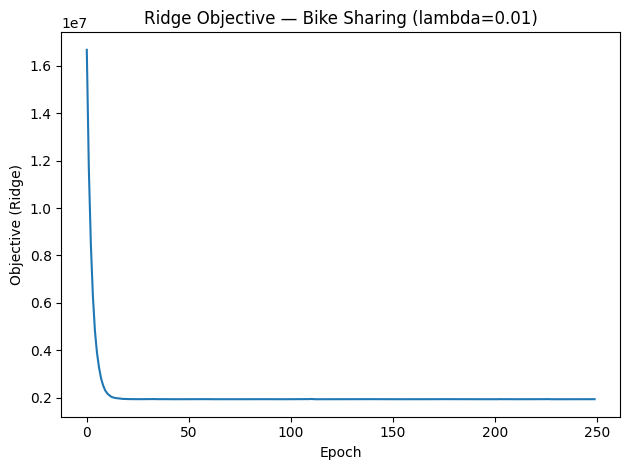

In [89]:

# 5) Plot training objective trajectory
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Objective (Ridge)")
plt.title(f"Ridge Objective — Bike Sharing (lambda={best_lam})")
plt.tight_layout()
plt.show()


### I verify shapes/finiteness and optionally inspect the learned coefficients (paired with feature names).

In [92]:

# Sanity checks: numeric consistency
for name, arr in [
    ("X_train", X_train), ("X_test", X_test),
    ("y_train", y_train), ("y_test", y_test),
    ("w_best", w_best), ("y_pred_test", y_pred_test)
]:
    assert np.isfinite(arr).all(), f"{name} contains non-finite values."

assert X_train.shape[1] == w_best.shape[0], "Weight dimension should match feature count (with intercept)."
assert y_pred_test.shape == y_test.shape, "Prediction/target shapes must match."

print("Sanity checks passed ✅")


# (Optional) show coefficients alongside feature names (excluding intercept)
coef_table = pd.DataFrame({
    'feature': ['(intercept)'] + feature_names,
    'weight':  w_best.ravel().tolist()
})
display(coef_table)


Sanity checks passed ✅


,feature,weight
0,(intercept),4513.493360
1,temp,735.131858
2,atemp,458.707195
3,hum,-519.968874
4,windspeed,-273.287177
5,workingday,18.123800
6,holiday,-83.347297
7,season_2,317.193951
8,season_3,76.998617
9,season_4,611.993141
